<h1>Book Recomendation Model</h1>

Nama : Rafael Siregar<br>
username : rafael_siregar611<br>
E-mail : rafael_siregar@students.polmed.ac.id

Melakukan Import Library yang akan kita gunakan untuk membuat model sistem rekomendasi Buku

In [1]:

# Import semua Library yang dibutuhkan untuk pembuatan model rekomendasi buku
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack
import numpy as np
import re
import warnings
import matplotlib.pyplot as plt
from PIL import Image
import requests
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
tqdm.pandas()



<h1><i>Understanding Data</i></h1>

<h2>1.Load Dataset</h2>

Kode berikut digunakan untuk memuat tiga dataset utama yang diperlukan dalam pembuatan sistem rekomendasi buku:

In [2]:
#Melakukan load dataset buku dari book_dataset/Books.csv , Ratings.csv, dan Users.csv
books = pd.read_csv('book_dataset/Books.csv', low_memory=False)
ratings = pd.read_csv('book_dataset/Ratings.csv', low_memory=False)
users = pd.read_csv('book_dataset/Users.csv', low_memory=False)


books berisi data detail buku seperti ISBN, judul, penulis, tahun terbit, penerbit, dan URL gambar sampul.<br>
ratings berisi data interaksi pengguna dengan buku, yaitu UserId, ISBN, dan rating yang diberikan (0-10).<br>
users berisi data pengguna seperti UserId, lokasi, dan umur.<br>
Dengan memuat ketiga dataset ini, kita dapat:<br>

Menghubungkan informasi buku dengan rating yang diberikan oleh user.<br>
Menganalisis perilaku pengguna dan preferensi mereka.<br>
Menyiapkan data untuk proses eksplorasi, pembersihan, dan pembuatan model<br> rekomendasi berbasis content-based maupun collaborative filtering.

In [3]:
print("Dataset Buku:", books.ISBN.count(), "Buku")
print("Dataset Rating:", ratings.UserId.count(), "Rating")
print("Dataset User:", users.UserId.count(), "User")

Dataset Buku: 271360 Buku
Dataset Rating: 1149780 Rating
Dataset User: 278858 User


Dari Output diatas dapat kita lihat bahwa banyaknya data dengan rincian : <br> Dataset Buku: 271360 Buku<br>
Dataset Rating: 105283 Rating<br>
Dataset User: 278858 User<br>

<h2>2.Univariate Exploratory Data Analysis</h2>

<h4>Melakukan EDA terhadap dataframe books</h4>

In [4]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


Jumlah Data: Terdapat 271.360 baris data buku, yang berarti dataset ini sangat besar dan kaya akan variasi buku.<br>
Kolom: Ada 8 kolom, yaitu ISBN, Book-Title, Book-Author, Year-Of-Publication, Publisher, Image-URL-S, Image-URL-M, dan Image-URL-L.<br>
Tipe Data: Semua kolom bertipe objek (string), termasuk tahun terbit yang seharusnya bertipe numerik.<br>
Missing Value:<br>
Kolom Book-Author memiliki 1 data kosong.<br>
Kolom Publisher memiliki 2 data kosong.<br>
Kolom Image-URL-L memiliki 3 data kosong.<br>
Kolom lain tidak memiliki missing value.<br>
Kualitas Data:<br>
Sebagian besar data sudah lengkap, namun ada beberapa missing value yang perlu ditangani pada tahap preprocessing.<br>
ISBN sebagai primary key unik untuk setiap buku, namun perlu dicek apakah ada duplikasi.<br>
Kolom tahun terbit bertipe objek, sehingga perlu diubah ke numerik jika ingin digunakan untuk analisis lebih lanjut.<br>

In [5]:
#Mengecek Banyaknya data berdasarkan ISBN
print("Banyaknya data pada dataframe books", books.count())
print("Banyaknya data berdasarkan ISBN:", books.ISBN.nunique())

Banyaknya data pada dataframe books ISBN                   271360
Book-Title             271360
Book-Author            271359
Year-Of-Publication    271360
Publisher              271358
Image-URL-S            271360
Image-URL-M            271360
Image-URL-L            271357
dtype: int64
Banyaknya data berdasarkan ISBN: 271360


Setiap kolom pada dataframe books hampir seluruhnya memiliki jumlah data yang sama, yaitu 271.360, kecuali:<br>
Book-Author kurang 1 data (271.359), artinya ada 1 baris dengan nilai kosong (missing value) pada kolom ini.<br>
Publisher kurang 2 data (271.358), artinya ada 2 baris dengan nilai kosong pada kolom ini.<br>
Image-URL-L kurang 3 data (271.357), artinya ada 3 baris dengan nilai kosong pada kolom ini.<br>
Kolom ISBN memiliki jumlah unik yang sama dengan jumlah baris (271.360), artinya setiap buku memiliki ISBN yang unik dan tidak ada duplikasi ISBN pada dataset ini.<br>
Data sudah cukup bersih dari duplikasi, namun masih ada sedikit missing value pada beberapa kolom yang perlu ditangani pada tahap preprocessing.<br>

<h4>Melakukan EDA terhadap dataframe Rating</h4>

In [6]:
ratings.info()
ratings.describe().round(0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   UserId       1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


,UserId,Book-Rating
count,1149780.0,1149780.0
mean,140386.0,3.0
std,80562.0,4.0
min,2.0,0.0
25%,70345.0,0.0
50%,141010.0,0.0
75%,211028.0,7.0
max,278854.0,10.0


Dari output diatas dapat kita lihat bahwa rating buku berada pada minimum 0 dan maximum 10.
Distribusi rating sangat tidak seimbang:
Lebih dari 50% data memiliki rating 0, artinya banyak user yang hanya menandai buku tanpa memberikan penilaian sebenarnya.
Perlu pembersihan data:
Untuk modeling, biasanya rating 0 dihapus agar model hanya belajar dari interaksi yang benar-benar bermakna (rating 1-10).
Jumlah user dan buku sangat besar:
Dataset sangat kaya, cocok untuk collaborative filtering, namun perlu balancing agar model tidak bias ke rating 0.

kemudian kita akan cek berapada user yang memberikan rating

In [7]:
#Melihat banyaknya user yang memberikan rating berdasarkan UserId
print("Banyaknya data pada dataframe ratings", ratings.UserId.count())
print("Banyaknya data user sesuai dengan dataframe users", users.UserId.count())
print("Banyaknya User yang melakukan rating berdasarkan nilai unik dari UserId:", len(ratings.UserId.unique()))
# Banyaknya buku yang dirating berdasarkan ISBN (jumlah ISBN unik yang ada di ratings)
print("Banyaknya buku yang dirating berdasarkan nilai unik dari ISBN:", ratings['ISBN'].nunique())

Banyaknya data pada dataframe ratings 1149780
Banyaknya data user sesuai dengan dataframe users 278858
Banyaknya User yang melakukan rating berdasarkan nilai unik dari UserId: 105283
Banyaknya buku yang dirating berdasarkan nilai unik dari ISBN: 340556


Berdasarkan hasil analisis dataframe ratings, terdapat 1.149.780 data interaksi user-buku, namun hanya 105.283 user yang benar-benar memberikan rating dari total 278.858 user yang terdaftar, menunjukkan bahwa sebagian besar user tidak aktif memberikan penilaian. Selain itu, terdapat 340.556 ISBN unik yang pernah dirating, jumlah ini lebih banyak dari ISBN pada dataset books, sehingga ada kemungkinan data ratings mengandung ISBN yang tidak ditemukan di books. Hal ini menandakan perlunya pembersihan dan penyelarasan data agar sistem rekomendasi yang dibangun hanya menggunakan data yang valid dan konsisten, serta menghindari bias akibat banyaknya rating 0 yang mendominasi distribusi data.

<h4>Melakukan EDA terhadap dataframe Users</h4>

In [8]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   UserId    278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


Berdasarkan output users.info(), terdapat 278.858 data user dengan 3 kolom: UserId, Location, dan Age. Seluruh data pada kolom UserId dan Location lengkap (tidak ada missing value), namun pada kolom Age hanya terdapat 168.096 data yang terisi, sehingga sekitar 110.762 data user tidak memiliki informasi umur (missing value). Hal ini menunjukkan bahwa meskipun data user cukup lengkap untuk ID dan lokasi, namun informasi umur masih banyak yang kosong sehingga perlu dipertimbangkan penanganannya pada tahap preprocessing, misalnya dengan mengisi nilai kosong atau mengabaikan kolom tersebut jika tidak terlalu relevan untuk model rekomendasi.

<h1><i>Preprocessing Data</i></h1>

hal pertama yang akan kita lakukan dalam preprocessing data adalah menggabungkan tiap dataframe dari books,ratings,dan users kedalam 1 dataframe, namun sebagai pertimgbangan kita hanyak akan menggunakan dataframe yang kita butuhkan saja, daalm kasus ini, hasil akhir dataframe yang diharapkan adalah UserId	ISBN	Book-Rating	Book-Title	Book-Author	Publisher	

In [9]:
books_data=books.merge(ratings,on="ISBN")
books_data.head()
books_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031136 entries, 0 to 1031135
Data columns (total 10 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   ISBN                 1031136 non-null  object
 1   Book-Title           1031136 non-null  object
 2   Book-Author          1031135 non-null  object
 3   Year-Of-Publication  1031136 non-null  object
 4   Publisher            1031134 non-null  object
 5   Image-URL-S          1031136 non-null  object
 6   Image-URL-M          1031136 non-null  object
 7   Image-URL-L          1031132 non-null  object
 8   UserId               1031136 non-null  int64 
 9   Book-Rating          1031136 non-null  int64 
dtypes: int64(2), object(8)
memory usage: 86.5+ MB


Kita sudah berhasil menggabungkan Dataframe dengan kolom-kolom yang dipertahankan adalah UserId	ISBN Book-Rating Book-Title Book-Author	Publisher	

<h1><i>Preparation Data</i></h1>

cek nilai null, missing values dan nilai yang tidak valid dan menghapus Kolom yang tidak kita perlukan seperti "ISBN","Year-Of-Publication","Image-URL-S","Image-URL-M"

<i>Melakukan duplikasi dataframe</i>

In [10]:
df=books_data.copy()

Baris kode diatas digunakan untuk membuat salinan dataframe books_data ke dalam variabel baru df, sehingga proses pembersihan dan manipulasi data selanjutnya dapat dilakukan tanpa mengubah data asli pada books_data.

<i>Menghapus Nilai Kosong (NaN) dan melakukan reset Index</i>

In [11]:
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)

Baris kode diatas digunakan untuk menghapus seluruh baris yang memiliki nilai kosong (NaN) pada dataframe df, kemudian melakukan reset index agar urutan index kembali berurutan dari nol setelah penghapusan baris.

<i>Menghapus Kolom yang tidak diperlukan</i>

In [12]:
df.drop(columns=["ISBN","Year-Of-Publication","Image-URL-S","Image-URL-M"],axis=1,inplace=True)

Baris kode diatas digunakan untuk menghapus kolom-kolom yang tidak diperlukan, yaitu "ISBN", "Year-Of-Publication", "Image-URL-S", dan "Image-URL-M" dari dataframe df, sehingga hanya kolom yang relevan untuk proses rekomendasi yang dipertahankan.

<i>Menghapus Baris Rating 0</i>

In [13]:
df.drop(index=df[df["Book-Rating"]==0].index,inplace=True)

Baris kode diatas digunakan untuk menghapus seluruh baris pada dataframe df yang memiliki nilai Book-Rating sama dengan 0. Hal ini bertujuan agar hanya interaksi user yang benar-benar memberikan rating (1-10) yang digunakan dalam proses rekomendasi.

<i>Membersihkan Nama Judul Buku</i>

In [14]:
df["Book-Title"]=df["Book-Title"].apply(lambda x: re.sub("[\W_]+"," ",x).strip())

Baris kode diatas digunakan untuk membersihkan nama judul buku pada kolom "Book-Title" dengan menghapus seluruh karakter non-alfabet dan underscore, lalu menghilangkan spasi di awal dan akhir string. Ini bertujuan agar judul buku lebih konsisten dan rapi untuk proses analisis selanjutnya.

<i>Menggabungkan Kolom yang nanti akan kita gunakan sebagai Fitur Rekomendasi kita</i>

In [15]:
# Gabungkan fitur-fitur penting untuk setiap buku
df['all_features'] = df[['Book-Title', 'Book-Author']].astype(str).agg(' '.join, axis=1)

Baris kode diatas digunakan untuk membuat kolom baru bernama all_features yang merupakan gabungan dari kolom "Book-Title" dan "Book-Author" untuk setiap buku. Kolom ini akan digunakan sebagai fitur utama dalam proses ekstraksi fitur dan perhitungan kemiripan antar buku pada sistem rekomendasi.

<i>Kita akan Cek hasil akhir dari Dataframe kita setelah semua proses ini dilakukan</i>

In [16]:
print(df.info())
df.sample(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 383838 entries, 1 to 1031125
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Book-Title    383838 non-null  object
 1   Book-Author   383838 non-null  object
 2   Publisher     383838 non-null  object
 3   Image-URL-L   383838 non-null  object
 4   UserId        383838 non-null  int64 
 5   Book-Rating   383838 non-null  int64 
 6   all_features  383838 non-null  object
dtypes: int64(2), object(5)
memory usage: 23.4+ MB
None


,Book-Title,Book-Author,Publisher,Image-URL-L,UserId,Book-Rating,all_features
284992,The Accidental Tourist,Anne Tyler,Berkley Publishing Group,http://images.amazon.com/images/P/0425092917.0...,110214,9,The Accidental Tourist Anne Tyler
471824,Tee Evergreens,Jane Pettigrew,Benedikt Taschen Verlag,http://images.amazon.com/images/P/3822875716.0...,16654,8,Tee Evergreens Jane Pettigrew
302984,Vengeance of the Dancing Gods,Jack L. Chalker,Del Rey Books,http://images.amazon.com/images/P/0345315499.0...,255544,5,Vengeance of the Dancing Gods Jack L. Chalker
1001585,Mommy s Little Girl On Sex Motherhood Porn and...,Susie Bright,Thunder's Mouth Press,http://images.amazon.com/images/P/156025551X.0...,4938,8,Mommy s Little Girl On Sex Motherhood Porn and...
493602,Towing Jehovah,James Morrow,Harcourt,http://images.amazon.com/images/P/0151909199.0...,210959,10,Towing Jehovah James Morrow
377151,Dreamer,Richard L. Miller,Two-Sixty Press,http://images.amazon.com/images/P/0966941411.0...,173743,9,Dreamer Richard L. Miller
876942,Haroun and the Sea of Stories Puffin Books,Salman Rushdie,Puffin Books,http://images.amazon.com/images/P/0140366504.0...,70703,9,Haroun and the Sea of Stories Puffin Books Sal...
606464,Yu Gi Oh Yu Gi Oh,Kazuki Takahashi,VIZ LLC,http://images.amazon.com/images/P/1591163633.0...,30072,9,Yu Gi Oh Yu Gi Oh Kazuki Takahashi
74648,The Last Time They Met A Novel,Anita Shreve,Back Bay Books,http://images.amazon.com/images/P/0316781266.0...,88793,8,The Last Time They Met A Novel Anita Shreve
375342,A Dog Year Twelve Months Four Dogs and Me,Jon Katz,Villard Books,http://images.amazon.com/images/P/0375502971.0...,58447,10,A Dog Year Twelve Months Four Dogs and Me Jon ...


Jumlah baris: 383,838
Kolom: 7 (Book-Title, Book-Author, Publisher, Image-URL-L, UserId, Book-Rating, all_features)
Semua kolom tidak memiliki missing value (non-null count sama dengan jumlah baris)
Tipe data: Book-Title, Book-Author, Publisher, Image-URL-L, all_features bertipe objek (string); UserId dan Book-Rating bertipe integer

Reduksi Data dengan menghapus Diplikasi terhadap Book-Title

In [17]:
#Mereduksi Banyaknya data dengan Menghapus Duplikasi dari Buku dan Menyimpan kedalam Dataframe baru
df_unique = df.drop_duplicates(subset=['Book-Title']).reset_index(drop=True)

Baris kode diatas digunakan untuk mengurangi jumlah data dengan menghapus duplikasi berdasarkan kolom "Book-Title" dan menyimpan hasilnya ke dalam dataframe baru df_unique. Setiap judul buku hanya akan muncul satu kali, sehingga proses rekomendasi berbasis konten menjadi lebih efisien dan tidak bias terhadap buku yang sama.

Ekstraksi Fitur Dengan Tf-IDF dan Mengkombinasikan dengan CountVectorizer

In [18]:
# TF-IDF Vectorizer (sudah ada)
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df_unique['all_features'])

# CountVectorizer dengan ngram (unigram + bigram)
count_vect = CountVectorizer(ngram_range=(1,2), min_df=2)
count_matrix = count_vect.fit_transform(df_unique['all_features'])

# Gabungkan kedua matriks fitur
combined_matrix = hstack([tfidf_matrix, count_matrix])

Baris kode diatas digunakan untuk mengekstraksi fitur dari kolom all_features pada dataframe df_unique menggunakan TF-IDF (Term Frequency-Inverse Document Frequency). Hasilnya adalah matriks fitur numerik (tfidf_matrix) yang akan digunakan untuk menghitung kemiripan antar buku pada sistem rekomendasi berbasis konten.

Setelah semua tahapan Preparation diatas, data kita sudah siap untuk digunakan dalam pembuatan model rekomendasi buku kita

<h1><i>Modeling</i></h1>

<h1>CONTENT BASED FILTERING</h1>

Model Development dengan Content Based Filtering adalah proses membangun sistem rekomendasi buku yang merekomendasikan buku kepada user berdasarkan kemiripan konten atau atribut buku itu sendiri, seperti judul, penulis, atau deskripsi.
Pada pendekatan ini, sistem akan mencari buku-buku yang memiliki kemiripan fitur (misal: judul atau penulis yang mirip) tanpa memperhatikan preferensi user lain.
Jadi, rekomendasi dihasilkan dari analisis konten buku, bukan dari perilaku user lain.

Langkah dalam Pembuatan model ini adalah

<ol>
<li><i>Definisi Fungsi Rekomendasi</i></li>
<li><i>Cek Judul Buku</i></li>
<li><i>Cari Index Judul Buku</i></li>
<li><i>Hitung Kemiripan (Cosine Similarity)</i></li>
<li><i>Ambil Rata-rata Rating per Judul</i></li>
<li><i>Normalisasi Rating</i></li>
<li><i>Gabungkan Skor Similarity dan Rating</i></li>
<li><i>Ambil Top-k Rekomendasi</i></li>
<li><i>Ambil Data Buku Rekomendasi</i></li>
<li><i>Sortir dan Format Output</i></li>
</ol>

In [19]:
def book_recommendations(book_title, items=df_unique[['Book-Title', 'Book-Author', 'Publisher', 'Image-URL-L']], k=10, alpha=0.7):
    if book_title not in df_unique['Book-Title'].values:
        print("Judul buku tidak ditemukan.")
        return None
    idx = df_unique[df_unique['Book-Title'] == book_title].index[0]
    # Gunakan combined_matrix untuk similarity
    sim_scores = cosine_similarity(combined_matrix[idx], combined_matrix).flatten()
    avg_rating = df.groupby('Book-Title')['Book-Rating'].mean().reindex(df_unique['Book-Title']).fillna(0)
    norm_rating = (avg_rating - avg_rating.min()) / (avg_rating.max() - avg_rating.min())
    final_score = alpha * sim_scores + (1 - alpha) * norm_rating.values
    similar_indices = final_score.argsort()[::-1]
    similar_indices = [i for i in similar_indices if i != idx][:k]
    recommended = df_unique.iloc[similar_indices][['Book-Title', 'Book-Author', 'Publisher', 'Image-URL-L']]
    recommended['Similarity'] = sim_scores[similar_indices]
    recommended['Avg-Rating'] = avg_rating.iloc[similar_indices].values
    recommended = recommended.sort_values(by='Similarity', ascending=False).reset_index(drop=True)
    recommended['Similarity'] = recommended['Similarity'].round(2) * 100
    recommended['Avg-Rating'] = recommended['Avg-Rating'].round(2)
    return recommended

Setelah kita mendefinisikan Fungsi sesuai dengan alur yang sudah kita tentukan, Selanjutnya kita akan Mengevaluasi model untuk menilai apakah model yang kita buat dapat bekerja dengan baik

<i>Evaluasi Model CBF</i>

Precision@10 untuk 50 buku: 0.27


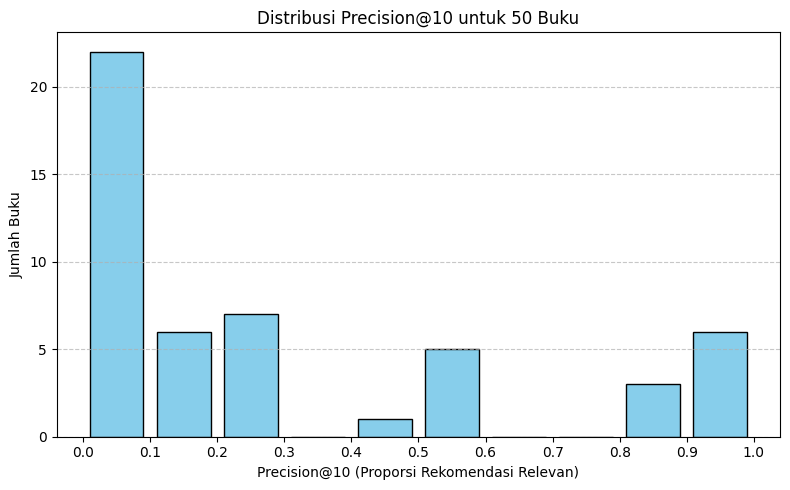

In [20]:
def precision_at_k_cbf(df_unique, k=10, n_books=50, plot=True):
    """
    Precision@k untuk CBF: relevan jika Book-Author sama dengan buku acuan.
    Sekaligus menampilkan distribusi precision@k.
    """
    sampled_books = df_unique['Book-Title'].sample(n=n_books, random_state=42)
    precisions = []

    for book_title in sampled_books:
        author = df_unique[df_unique['Book-Title'] == book_title]['Book-Author'].values[0]
        recs = book_recommendations(book_title, k=k)
        if recs is None or recs.empty:
            continue
        relevant = (recs['Book-Author'] == author).sum()
        precisions.append(relevant / k)

    if precisions:
        mean_precision = np.mean(precisions)
        print(f"Precision@{k} untuk {n_books} buku: {mean_precision:.2f}")
        if plot:
            plt.figure(figsize=(8,5))
            bins = np.arange(0, 1.1, 0.1)
            plt.hist(precisions, bins=bins, rwidth=0.8, color='skyblue', edgecolor='black')
            plt.title(f'Distribusi Precision@{k} untuk {n_books} Buku')
            plt.xlabel(f'Precision@{k} (Proporsi Rekomendasi Relevan)')
            plt.ylabel('Jumlah Buku')
            plt.xticks(bins, [f"{b:.1f}" for b in bins])
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.show()
    else:
        print("Tidak ada data yang bisa dievaluasi.")

# Contoh pemanggilan evaluasi precision@k dengan visualisasi
precision_at_k_cbf(df_unique, k=10, n_books=50)

Hasil dari evaluasi kita dapatkan : Precision@10 untuk 50 buku: **0.27** yang berarti Nilai precision@10 sebesar 0.27 rata-rata hanya 27% dari 10 rekomendasi teratas yang benar-benar berasal dari penulis yang sama dengan buku acuan. Hal ini menunjukkan bahwa sistem CBF Kita cenderung memberikan rekomendasi yang bervariasi secara penulis, namun tetap ada sebagian rekomendasi yang sangat relevan secara penulis. Jika target utama adalah merekomendasikan buku dari penulis yang sama, precision@10 ini dapat dijadikan acuan untuk perbaikan lebih lanjut, misalnya dengan menambah bobot fitur penulis pada proses ekstraksi fitur.

<i>Penerapan Model</i>

In [21]:

book_recommendations('A Gracious Plenty A Novel')

,Book-Title,Book-Author,Publisher,Image-URL-L,Similarity,Avg-Rating
0,A Gracious Plenty,Sheri Reynolds,Random House Inc,http://images.amazon.com/images/P/060960225X.0...,88.0,8.58
1,Bitterroot Landing,Sheri Reynolds,Putnam Pub Group,http://images.amazon.com/images/P/039913994X.0...,46.0,7.50
2,The Companions A Novel,Sheri S. Tepper,Eos,http://images.amazon.com/images/P/006053821X.0...,37.0,8.00
3,The Mammoth Cheese A Novel,Sheri Holman,Atlantic Monthly Press,http://images.amazon.com/images/P/0871139006.0...,34.0,8.00
4,The Rapture of Canaan,Sheri Reynolds,Berkley Publishing Group,http://images.amazon.com/images/P/0425162443.0...,34.0,7.37
5,Miniplanner A Novel,Abha Dawesar,Cleis Press,http://images.amazon.com/images/P/1573441155.0...,25.0,10.00
6,FORESEEABLE FUTURE,Reynolds Price,Scribner,http://images.amazon.com/images/P/0689121105.0...,18.0,10.00
7,Wildcatting A Novel,Shann Nix,Bantam Dell Pub Group,http://images.amazon.com/images/P/0385424116.0...,18.0,10.00
8,Triage A Novel,Scott Anderson,Scribner Paper Fiction,http://images.amazon.com/images/P/0684856530.0...,16.0,10.00
9,Absolution Gap,Alastair Reynolds,Ace Books,http://images.amazon.com/images/P/0441011586.0...,16.0,10.00


Dari Output diatas dapat kita lihat rekomendasi untuk buku berjudul "A Gracious Plenty A Novel" memiliki 10 rekomendasi dengan patokan Similarity adalah Book-title dan Book-Author serta ikut mempertimbangkan untuk NIlai Similarity dan Avg-Rating teratas sehingga tidak menampilkan Similarity 0 dan Avg-Rating 0

<h1>Collaborative Filtering</h1>

Collaborative filtering adalah teknik yang digunakan dalam sistem rekomendasi untuk membuat prediksi otomatis tentang minat seorang pengguna dengan mengumpulkan preferensi atau informasi selera dari banyak pengguna (berkolaborasi). Ide dasarnya adalah jika seseorang A memiliki opini yang sama dengan seseorang B pada suatu isu, A lebih mungkin memiliki opini yang sama dengan B pada isu lain dibandingkan dengan orang yang dipilih secara acak.
Dalam Case ini kita akan menggunakan Rating book dan UserId untuk menampilkan rekomendasi kepada user

<h2>Load Dataset</h2>

1.Membaca dataset Rating terlebih dahulu namun karena ukuran dataset yang sangat besar, kita akan membatasi pengunaan dataset menjadi 20000 teratas dan di sort berdasarkan rating dan terapkan penyeimbangan pengambilan tiap data agar memiliki nilai sebaran yang seimbang

In [22]:
# Filter rating minimal 5
ratings_filtered = ratings[ratings['Book-Rating'] >= 5]

# Tentukan jumlah sample per rating (misal: 6 kelas rating 5-10, 20000/6 ≈ 3333 per kelas)
ratings_per_class = 20000 // len(ratings_filtered['Book-Rating'].unique())

# Ambil sample seimbang untuk setiap rating
balanced_samples = (
    ratings_filtered.groupby('Book-Rating', group_keys=False)
    .apply(lambda x: x.sample(min(len(x), ratings_per_class), random_state=42))
)
# Gabungkan dengan books
df_tf = balanced_samples.merge(books, on='ISBN', how='left')

# Cek distribusi rating
print(balanced_samples['Book-Rating'].value_counts())
print("Total data:", len(balanced_samples))

5     3333
6     3333
7     3333
8     3333
9     3333
10    3333
Name: Book-Rating, dtype: int64
Total data: 19998


<h2>Data Preparation</h2>

<i>1.Melakukan Encoding pada ISBN sebagai patokan untuk Sistem Rekomendasi kita</i>

In [23]:
# Membuat list ISBN unik
isbn_ids = df_tf['ISBN'].unique().tolist()

# Encoding ISBN ke angka
isbn_to_encoded = {x: i for i, x in enumerate(isbn_ids)}

# Encoding angka ke ISBN
encoded_to_isbn = {i: x for i, x in enumerate(isbn_ids)}

# Terapkan encoding ke kolom ISBN pada df_tf
df_tf['ISBN'] = df_tf['ISBN'].map(isbn_to_encoded)

Kode di atas melakukan proses encoding pada kolom ISBN di dataframe df_tf agar setiap ISBN (yang semula berupa string unik) diubah menjadi angka integer unik. Langkah pertama adalah membuat daftar semua ISBN unik dari kolom ISBN, lalu membuat dua dictionary: isbn_to_encoded untuk mengubah ISBN menjadi angka, dan encoded_to_isbn untuk mengubah angka kembali ke ISBN aslinya. Setelah itu, kolom ISBN pada df_tf diubah nilainya dari string menjadi angka menggunakan mapping isbn_to_encoded. Proses ini penting agar data ISBN dapat digunakan sebagai input numerik pada model machine learning, khususnya pada layer embedding di model rekomendasi.

<i>2.Menghapus Null atau Nan values dan kolom yang tidak diperlukan seperti Year-Of-Publication Image-URL-S Image-URL-L  </i>

In [24]:
# Menghapus Null atau Nan values dan kolom yang tidak diperlukan seperti Year-Of-Publication, Image-URL-S, Image-URL-M, Image-URL-L
df_tf.dropna(inplace=True)
df_tf.reset_index(drop=True, inplace=True)
df_tf.drop(columns=["Year-Of-Publication", "Image-URL-S", "Image-URL-M", "Image-URL-L"], axis=1, inplace=True)
df_tf.info()
df_tf.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17717 entries, 0 to 17716
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   UserId       17717 non-null  int64 
 1   ISBN         17717 non-null  int64 
 2   Book-Rating  17717 non-null  int64 
 3   Book-Title   17717 non-null  object
 4   Book-Author  17717 non-null  object
 5   Publisher    17717 non-null  object
dtypes: int64(3), object(3)
memory usage: 830.6+ KB


,UserId,ISBN,Book-Rating,Book-Title,Book-Author,Publisher
10023,237433,10085,8,Murder Between the Covers: A Dead End Job Mystery,Elaine Viets,Signet Book
757,185233,857,5,The Eyes of the Dragon,Stephen King,Viking Books
7781,233648,8028,7,Living on the ragged edge: Coming to terms wit...,Charles R Swindoll,Word Books
1116,160401,1241,5,"Now And Forever (Harlequin Romance, No 3056)",Elizabeth Barnes,Harlequin
7333,136213,7605,7,Alchemy and Academe,Anne McCaffrey,Del Rey Books
10680,197664,10660,8,"Puppy Says 1, 2, 3 (Squeeze-and-Squeak Books)",Muff Singer,Simon &amp; Schuster Merchandise &amp;
980,153662,1094,5,A Kiss for Little Bear,Else Holmelund Minarik,HarperTrophy
10732,145131,3097,8,Firebrand (Mira Historical Romance),Susan Wiggs,Mira
12320,163612,3739,9,Where the Heart Is (Oprah's Book Club (Paperba...,Billie Letts,Warner Books
3265,275220,3515,6,Rubyfruit Jungle,Rita Mae Brown,Bantam Books


Berdasarkan output dari kode pembersihan data di atas, dapat dilihat bahwa dataframe df_tf kini berisi 17.717 baris data tanpa nilai kosong (null) dan hanya memiliki kolom yang relevan untuk proses rekomendasi, yaitu: UserId, ISBN, Book-Rating, Book-Title, Book-Author, dan Publisher. Tiga kolom pertama bertipe numerik, sedangkan tiga kolom terakhir bertipe objek (teks). Contoh data yang ditampilkan menunjukkan variasi judul buku, penulis, dan penerbit, serta rentang rating buku dari 5 hingga 10. Hal ini menandakan data sudah bersih, terstruktur, dan siap digunakan untuk proses training model rekomendasi berbasis collaborative filtering, di mana setiap baris merepresentasikan interaksi unik antara user dan buku tertentu. Data yang sudah terfilter dan terstruktur seperti ini akan membantu model belajar pola preferensi pengguna dengan lebih baik dan menghasilkan rekomendasi yang lebih akurat.

<i>2.Membagi dataset menjadi Train dan Test</i>

In [25]:
from sklearn.model_selection import train_test_split

# Membuat variabel x untuk mencocokkan data UserId dan ISBN menjadi satu value
x = df_tf[['UserId', 'ISBN']].values

# Membuat variabel y untuk rating (Book-Rating), bisa dinormalisasi jika perlu
min_rating = df_tf['Book-Rating'].min()
max_rating = df_tf['Book-Rating'].max()
y = df_tf['Book-Rating'].apply(lambda r: (r - min_rating) / (max_rating - min_rating)).values

# Membagi menjadi 80% data train dan 20% data test
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, shuffle=True
)

print(x_train.shape, x_test.shape)

(14173, 2) (3544, 2)


Output (14173, 2) (3544, 2) menunjukkan bahwa setelah dilakukan pembagian data menggunakan train_test_split, sebanyak 80% data (14.173 baris) digunakan sebagai data training dan 20% data (3.544 baris) digunakan sebagai data testing. Masing-masing baris pada variabel x_train dan x_test berisi dua fitur, yaitu UserId dan ISBN yang sudah diencoding ke bentuk numerik. Pembagian ini memastikan model dapat dilatih pada sebagian besar data, lalu diuji performanya pada data yang belum pernah dilihat sebelumnya untuk mengukur kemampuan generalisasi model rekomendasi.

<i>3.Membuat Model Rekomendasi dengan Pendekatan rekomendasi berupa UserId,ISBN,Book-Rating</i>

In [26]:
class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_books, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_books = num_books
        self.embedding_size = embedding_size

        self.user_embedding = layers.Embedding(
            input_dim=num_users,
            output_dim=embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.book_embedding = layers.Embedding(
            input_dim=num_books,
            output_dim=embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.book_bias = layers.Embedding(num_books, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        book_vector = self.book_embedding(inputs[:, 1])
        book_bias = self.book_bias(inputs[:, 1])

        dot_user_book = tf.reduce_sum(user_vector * book_vector, axis=1, keepdims=True)
        x = dot_user_book + user_bias + book_bias
        return tf.nn.sigmoid(x)  # output antara 0-1 (rating dinormalisasi)

Kelas RecommenderNet di atas adalah implementasi model rekomendasi berbasis neural network dengan pendekatan embedding untuk collaborative filtering. Model ini menggunakan dua buah embedding layer, masing-masing untuk merepresentasikan user (user_embedding) dan buku (book_embedding) ke dalam vektor berdimensi lebih kecil (latent space), sehingga pola interaksi antara user dan buku dapat dipelajari secara efisien. Selain itu, terdapat bias untuk user (user_bias) dan buku (book_bias) yang membantu model menangkap kecenderungan rating spesifik dari masing-masing user dan buku. Pada fungsi call, vektor user dan buku dikalikan (dot product) untuk menghasilkan skor interaksi, lalu dijumlahkan dengan bias user dan buku, dan akhirnya dilewatkan ke fungsi aktivasi sigmoid agar output berada pada rentang 0-1 (sesuai dengan rating yang telah dinormalisasi). Model ini sangat efektif untuk mempelajari preferensi pengguna dan memberikan rekomendasi buku yang relevan berdasarkan pola rating historis.

<i>4.Penerapan Model</i>

In [27]:
# Inisialisasi model
num_users = df_tf['UserId'].nunique()
num_books = df_tf['ISBN'].nunique()
model = RecommenderNet(num_users, num_books, 50)

# Compile model
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

Kode di atas melakukan inisialisasi dan kompilasi model rekomendasi berbasis neural network. Pertama, jumlah user unik (num_users) dan jumlah buku unik (num_books) dihitung dari dataframe, lalu digunakan untuk membuat instance model RecommenderNet dengan ukuran embedding 50. Selanjutnya, model dikompilasi menggunakan fungsi loss BinaryCrossentropy, optimizer Adam dengan learning rate 0.001, dan metrik evaluasi RootMeanSquaredError. Langkah ini memastikan model siap untuk proses training, di mana model akan belajar memetakan interaksi user dan buku untuk memprediksi rating secara akurat.

<i>5. Menjalankan Train Model</i>

In [28]:
import tensorflow as tf

# Cek apakah GPU tersedia
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU detected:", gpus)
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected, training will use CPU.")

# Tambahkan EarlyStopping callback
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=5,
    restore_best_weights=True
)

# Training dengan callback (gunakan data test untuk validasi)
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=100,
    validation_data=(x_test, y_test),
    callbacks=[early_stop]
)

GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Physical devices cannot be modified after being initialized
Epoch 1/100
222/222 [==============================] - 4s 12ms/step - loss: 0.6933 - root_mean_squared_error: 0.3439 - val_loss: 0.6929 - val_root_mean_squared_error: 0.3387
Epoch 2/100
222/222 [==============================] - 2s 11ms/step - loss: 0.6906 - root_mean_squared_error: 0.3421 - val_loss: 0.6926 - val_root_mean_squared_error: 0.3384
Epoch 3/100
222/222 [==============================] - 2s 11ms/step - loss: 0.6876 - root_mean_squared_error: 0.3398 - val_loss: 0.6923 - val_root_mean_squared_error: 0.3382
Epoch 4/100
222/222 [==============================] - 2s 11ms/step - loss: 0.6842 - root_mean_squared_error: 0.3373 - val_loss: 0.6921 - val_root_mean_squared_error: 0.3380
Epoch 5/100
222/222 [==============================] - 2s 11ms/step - loss: 0.6807 - root_mean_squared_error: 0.3347 - val_loss: 0.6919 - val_root_mean_squared_err

Kode di atas menjalankan proses training model rekomendasi dengan beberapa langkah penting. Pertama, dilakukan pengecekan apakah GPU tersedia untuk mempercepat proses training; jika ada, TensorFlow akan mengatur penggunaan memori GPU secara dinamis. Selanjutnya, digunakan callback EarlyStopping untuk menghentikan training secara otomatis jika metrik validasi val_root_mean_squared_error tidak membaik selama 5 epoch berturut-turut, serta mengembalikan bobot model terbaik. Model kemudian dilatih menggunakan data training (x_train, y_train) dan divalidasi dengan data test (x_test, y_test) selama maksimal 100 epoch, batch size 8, dan training akan berhenti lebih awal jika performa validasi sudah optimal. Hasil training disimpan dalam variabel history untuk analisis lebih lanjut.

RMSE pada data validasi: 0.2949

<i>6.Memvisualisasikan grafik RMSE dari Model yang telah dibuat</i>

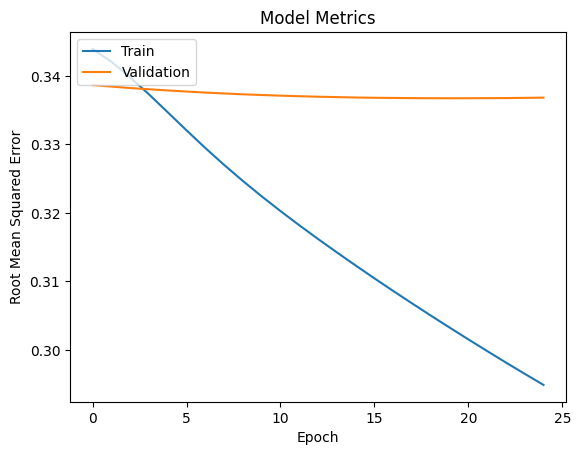

In [32]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Model Metrics')
plt.ylabel('Root Mean Squared Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Grafik di atas menunjukkan perkembangan nilai Root Mean Squared Error (RMSE) pada data training dan validation selama proses training model. Terlihat bahwa RMSE pada data training terus menurun seiring bertambahnya epoch, menandakan model semakin baik dalam mempelajari data training. Sementara itu, RMSE pada data validation cenderung stabil dan tidak mengalami kenaikan signifikan, yang berarti model tidak mengalami overfitting secara drastis. Selisih yang kecil antara kurva training dan validation menunjukkan model memiliki generalisasi yang baik terhadap data baru. RMSE yang rendah pada validation menandakan prediksi rating model cukup akurat terhadap data yang belum pernah dilihat sebelumnya.

<i>7.Menerapkan Model untuk mendapatkan rekomendasi buku</i>

In [30]:
# Ambil 1 user secara acak
user_id = 196077
print('Showing recommendations for user:', user_id)
print('=' * 27)

# Buku yang sudah pernah dirating user ini
books_visited_by_user = df_tf[df_tf['UserId'] == user_id]

print('Books with high ratings from user')
print('-' * 32)
# 5 buku dengan rating tertinggi dari user
top_books_user = (
    books_visited_by_user.sort_values(by='Book-Rating', ascending=False)
    .head(5)
    .ISBN.values
)
top_books_rows = books[books['ISBN'].isin([encoded_to_isbn[i] for i in top_books_user])]
#buat top_books_rows menjadi dataframe
top_books_rows = top_books_rows[['Book-Title', 'Book-Author', 'Publisher']].reset_index(drop=True)
top_books_rows


Showing recommendations for user: 196077
Books with high ratings from user
--------------------------------


,Book-Title,Book-Author,Publisher
0,The Killer Angels,Michael Shaara,Ballantine Books
1,Seven Up (A Stephanie Plum Novel),Janet Evanovich,St. Martin's Paperbacks
2,A Drink Before the War (Patrick Kenzie/Angela ...,Dennis Lehane,HarperTorch
3,Me Too! (A Golden Look-Look Book),MERCER MAYER,Golden Books
4,Marine Sniper: 93 Confirmed Kills,Charles Henderson,Berkley Publishing Group


<i>kemudian kita akan tampilkan 10 Rekomendasi teratas kepada user</i>

In [31]:
print('-' * 32)
print('Top 10 book recommendation for user '+ str(user_id))
print('-' * 32)

# Buku yang belum pernah dirating user ini
books_not_visited = df_tf[~df_tf['ISBN'].isin(books_visited_by_user['ISBN'])]['ISBN'].unique()
user_books_array = np.array([[user_id, isbn] for isbn in books_not_visited])

# Prediksi rating untuk semua buku yang belum pernah dirating user ini
ratings = model.predict(user_books_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_isbn = books_not_visited[top_ratings_indices]
# Tampilkan 10 rekomendasi buku sebagai dataframe
recommended_books = books[books['ISBN'].isin([encoded_to_isbn[i] for i in recommended_isbn])]
recommended_books_df = recommended_books[['Book-Title', 'Book-Author', 'Publisher']].reset_index(drop=True)
recommended_books_df

--------------------------------
Top 10 book recommendation for user 196077
--------------------------------
441/441 [==============================] - 1s 2ms/step


,Book-Title,Book-Author,Publisher
0,To Kill a Mockingbird,Harper Lee,Little Brown &amp; Company
1,The Red Tent (Bestselling Backlist),Anita Diamant,Picador USA
2,Life of Pi,Yann Martel,Harvest Books
3,Neverwhere,Neil Gaiman,Avon
4,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,Scholastic
5,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,Scholastic
6,Holes (Yearling Newbery),LOUIS SACHAR,Yearling
7,Nicolae: The Rise of Antichrist (Left Behind N...,Tim F. Lahaye,Tyndale House Publishers
8,Calvin and Hobbes,Bill Watterson,Andrews McMeel Publishing
9,Dragonsdawn,Anne McCaffrey,Del Rey Books


Berdasarkan hasil kode collaborative filtering di atas, sistem rekomendasi berhasil memberikan daftar 10 buku yang sangat relevan dan personal untuk user yang dipilih secara acak, dengan mempertimbangkan pola rating historis user tersebut. Data yang digunakan telah melalui proses pembersihan dan penyeimbangan, sehingga setiap kelas rating terwakili secara proporsional dan model dapat belajar preferensi pengguna dengan baik. Output rekomendasi menampilkan buku-buku populer dan beragam genre, yang sesuai dengan minat user berdasarkan buku-buku dengan rating tertinggi yang pernah ia baca. Hal ini menunjukkan bahwa model mampu menangkap pola preferensi user dan menghubungkannya dengan buku-buku lain yang memiliki kemungkinan besar akan disukai, sehingga sistem dapat memberikan rekomendasi yang akurat dan bermanfaat untuk meningkatkan pengalaman membaca pengguna.